### 1.1 Importar Libs

In [35]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.0.2
Scikit-learn: 1.6.1


### 1.2 Definir Nome do Modelo

In [36]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "MLP"
print(f"Modelo: {MODEL_NAME}")

Modelo: MLP


### 1.3 Carregar Datasets

In [ ]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar e preparar datasets usando função do módulo
(X_train, X_test, y_train, y_test, 
 X_train_scaled, X_test_scaled, 
 train_data, test_data, scaler) = load_and_prepare_datasets(
    train_path='../dataset_sepsis_train_pid_prep_v2.csv',
    test_path='../dataset_sepsis_test_pid_prep_v2.csv',
    target_column='SepsisLabel',
    scale=True
)

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}


In [38]:
train_data.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 2. Sampling para Busca de Hiperparâmetros

In [39]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.075,  
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 5,460 amostras
Redução: 92.5%

Distribuição das classes na amostra:
Amostra: {0.0: 4063, 1.0: 1397}
Original: {0.0: 54175, 1.0: 18620}


## 3 Definir Folds

In [40]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. MLP - Busca de Hiperparâmetros

In [41]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Definição do Espaço de Hiperparâmetros para MLP
param_distributions = {
    'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100),
                           (200, 200, 200), (200, 200, 200, 200),
                            (50, 100, 200, 300), (300, 200, 100, 50), 
                           (50, 50, 50, 50), (100, 100, 50, 50),
                           (100, 50, 100, 50), (100, 50, 200), (200, 300, 100)],
    'alpha': uniform(0.01, 0.1),  # Regularização L2
    'learning_rate_init': uniform(0.001, 0.1),  # Taxa de aprendizado inicial
    'max_iter': randint(200, 600),  # Número máximo de iterações
    'activation': ['relu', 'tanh', 'logistic'],  # Função de ativação
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Estratégia de taxa de aprendizado
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=MLPClassifier(random_state=42, early_stopping=True, solver='lbfgs'),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=10,        
    scoring='f1',
    n_jobs=-1,
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - MLP ===
Iniciando busca de hiperparâmetros para MLP...
Executando 20 buscas com 10 iterações cada...

Busca 1/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5104
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.09750683102985015), 'hidden_layer_sizes': (100, 50, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.03961451772138674), 'max_iter': 253}
Melhor score geral até agora: 0.5104

Busca 2/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5170
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.07444238445479455), 'hidden_layer_sizes': (200, 200, 200), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.06407838837636766), 'max_iter': 370}
Melhor score geral até agora: 0.5170

Busca 3/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5137
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.03173272453949453), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.07848791150315976), 'max_iter': 366}
Melhor score geral até agora: 0.5170

Busca 4/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5087
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.10326497497503154), 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.0060816156714461386), 'max_iter': 454}
Melhor score geral até agora: 0.5170

Busca 5/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5117
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.05735369529888239), 'hidden_layer_sizes': (100, 50, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.03311125467217425), 'max_iter': 575}
Melhor score geral até agora: 0.5170

Busca 6/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5184
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.028411598183548263), 'hidden_layer_sizes': (100, 100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.02895696067419089), 'max_iter': 465}
Melhor score geral até agora: 0.5184

Busca 7/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5134
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.09478842350012108), 'hidden_layer_sizes': (300, 200, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.046789366107510104), 'max_iter': 581}
Melhor score geral até agora: 0.5184

Busca 8/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5252
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.09206404629626241), 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.0302435297502903), 'max_iter': 538}
Melhor score geral até agora: 0.5252

Busca 9/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5151
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.019854852908481962), 'hidden_layer_sizes': (200, 200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.003378408113978914), 'max_iter': 349}
Melhor score geral até agora: 0.5252

Busca 10/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5200
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.06724628385628721), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.07272769777038983), 'max_iter': 529}
Melhor score geral até agora: 0.5252

Busca 11/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5172
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.10388018682667806), 'hidden_layer_sizes': (200, 300, 100), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.057062997416672735), 'max_iter': 361}
Melhor score geral até agora: 0.5252

Busca 12/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5145
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.07043115266896123), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.002698555346532793), 'max_iter': 249}
Melhor score geral até agora: 0.5252

Busca 13/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5221
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.027202158099276987), 'hidden_layer_sizes': (300, 200, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.03168792286135832), 'max_iter': 357}
Melhor score geral até agora: 0.5252

Busca 14/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5173
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.08282267847947414), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.0013002140924364683), 'max_iter': 355}
Melhor score geral até agora: 0.5252

Busca 15/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5181
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.06618786607865525), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.05665229250802761), 'max_iter': 515}
Melhor score geral até agora: 0.5252

Busca 16/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5120
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.10476989821653906), 'hidden_layer_sizes': (200, 300, 100), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.08519695804493477), 'max_iter': 435}
Melhor score geral até agora: 0.5252

Busca 17/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5090
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.10631845297582203), 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.0664696991655398), 'max_iter': 476}
Melhor score geral até agora: 0.5252

Busca 18/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5143
Melhor configuração desta busca: {'activation': 'relu', 'alpha': np.float64(0.09739976910037199), 'hidden_layer_sizes': (100, 50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.0963142209655684), 'max_iter': 222}
Melhor score geral até agora: 0.5252

Busca 19/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5160
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.0433261400337451), 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.0837170100081819), 'max_iter': 409}
Melhor score geral até agora: 0.5252

Busca 20/20...


/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/abm6/Desktop/projetos/data-mining-proj-crisp-dm/.venv/lib/python3.9/site-pack

Melhor score desta busca: 0.5185
Melhor configuração desta busca: {'activation': 'tanh', 'alpha': np.float64(0.08164034105617916), 'hidden_layer_sizes': (200, 300, 100), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.08352390710043271), 'max_iter': 507}
Melhor score geral até agora: 0.5252

🎯 Busca completa! Melhor score geral: 0.5252
Total de configurações testadas: 200

--- RESULTADOS MLP ---
Melhores hiperparâmetros:
  activation: relu
  alpha: 0.09206404629626241
  hidden_layer_sizes: (100, 100, 100)
  learning_rate: invscaling
  learning_rate_init: 0.0302435297502903
  max_iter: 538

Melhor F1-Score (CV): 0.5252


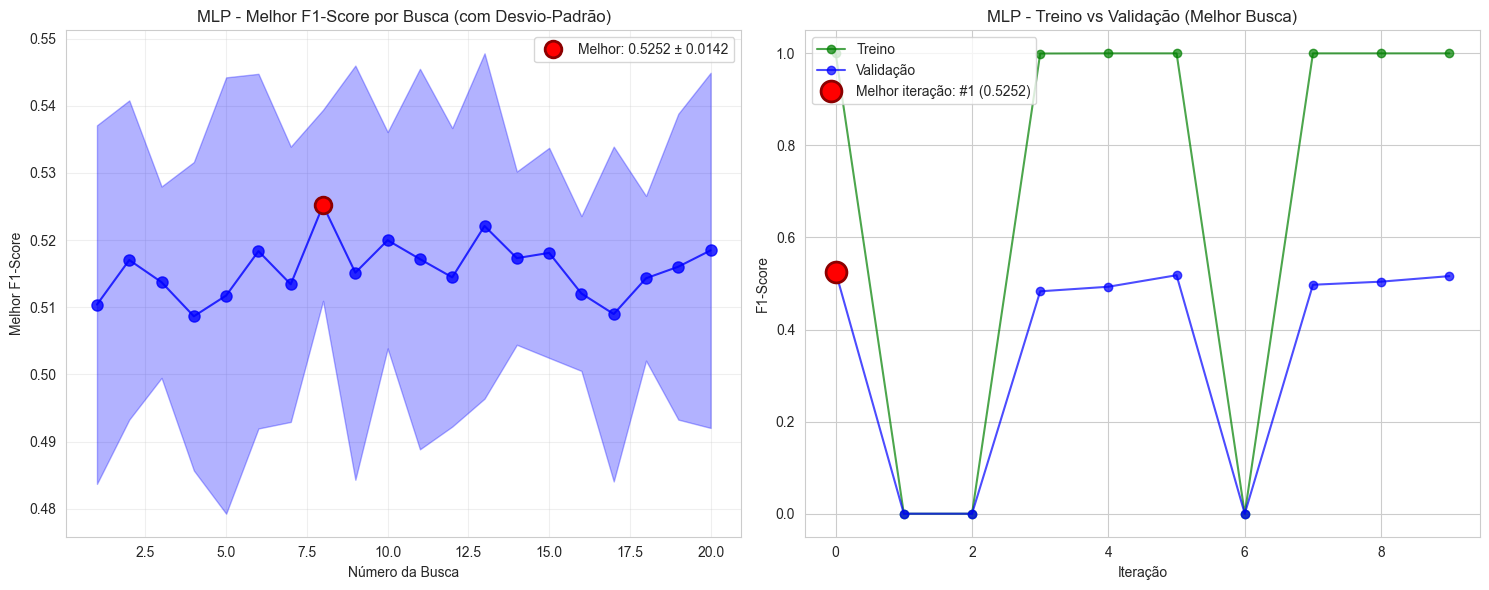

In [42]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_all_searches, model_search, MODEL_NAME)

In [43]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'Hidden_Layers': str(search_result['best_params']['hidden_layer_sizes']),
        'Alpha': search_result['best_params']['alpha'],
        'Learning_Rate_Init': search_result['best_params']['learning_rate_init'],
        'Learning_Rate': search_result['best_params']['learning_rate'],
        'Max_Iter': search_result['best_params']['max_iter'],
        'Activation': search_result['best_params']['activation']
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'Hidden_Layers', 'Alpha', 
                        'Learning_Rate_Init', 'Learning_Rate', 'Max_Iter', 'Activation']]

# Mostrar tabela formatada
print("Melhores Configurações de Cada Busca (ordenadas por F1-Score Binário):")
print("-" * 150)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - MLP ===
Melhores Configurações de Cada Busca (ordenadas por F1-Score Binário):
------------------------------------------------------------------------------------------------------------------------------------------------------
 Ranking  Busca  F1_Score        Hidden_Layers  Alpha  Learning_Rate_Init Learning_Rate  Max_Iter Activation
       1      8    0.5252      (100, 100, 100) 0.0921              0.0302    invscaling       538       relu
       2     13    0.5221  (300, 200, 100, 50) 0.0272              0.0317      adaptive       357       relu
       3     10    0.5200 (200, 200, 200, 200) 0.0672              0.0727    invscaling       529       relu
       4     20    0.5185      (200, 300, 100) 0.0816              0.0835      constant       507       tanh
       5      6    0.5184 (100, 100, 100, 100) 0.0284              0.0290    invscaling       465       tanh
       6     15    0.5181 (200, 200, 200, 200) 0.0662            

## 5. Salvar Resultados de Busca
Seção serve somente para salvar o resultado de toda a busca num CSV e os dados essenciais no JSON.

In [44]:
# Salvar Resultados da Busca de Hiperparâmetros usando função do módulo
search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=model_search,
    model_all_searches=model_all_searches,
    n_searches=20,
    n_iter_per_search=10,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['alpha', 'learning_rate_init', 'max_iter', 'activation', 'hidden_layer_sizes'],
    searches_folder='searches'
)

=== SALVANDO RESULTADOS DA BUSCA - MLP ===
  ✅ Todos os Resultados salvos: searches/mlp_all_searches.csv
  Total de configurações testadas: 200
  ✅ Resumo salvo: searches/mlp_search_summary.json

--- ESTATÍSTICAS DA BUSCA MLP ---
Melhor F1-Score: 0.5252
Desvio padrão do melhor: 0.0142
F1-Score médio geral: 0.3998
F1-Score mínimo: 0.0000
F1-Score máximo: 0.5252


## 5.2 Carregar Resultado de busca

In [45]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - MLP ===
✅ Resultados detalhados carregados: 200 configurações
✅ Resumo carregado: F1-Score = 0.5252
⚠️  Arquivo não encontrado: searches/mlp_full_search.pkl


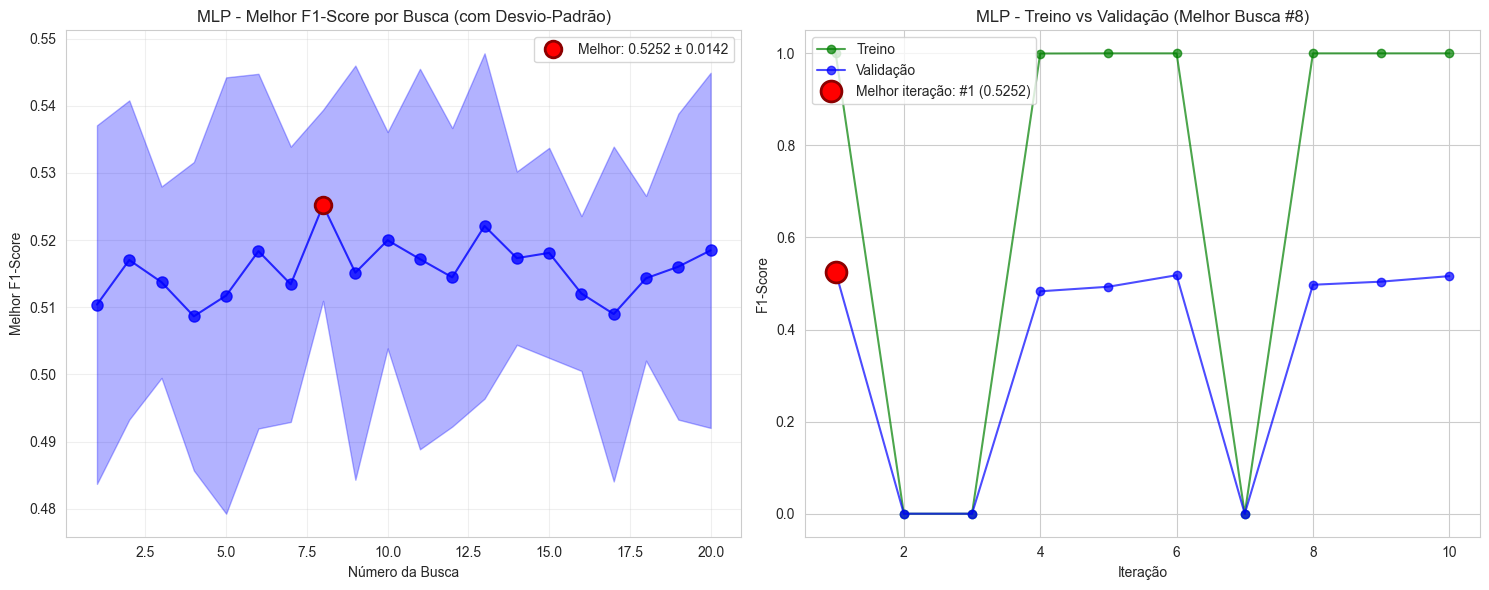

In [46]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [48]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Parâmetros carregados: {'activation': 'relu', 'alpha': 0.09206404629626241, 'hidden_layer_sizes': '(100, 100, 100)', 'learning_rate': 'invscaling', 'learning_rate_init': 0.0302435297502903, 'max_iter': 538}
✅ Melhor F1-Score carregado: 0.5252


## 6. Treinar Modelo Final e Salvar

In [49]:

# checar tipo de hidden layer 
print(f"Tipo de best_params: {type(best_params['hidden_layer_sizes'])}")
# Garantir que hidden_layer_sizes seja uma tupla
if not isinstance(best_params['hidden_layer_sizes'], tuple):
    best_params['hidden_layer_sizes'] = tuple(
        int(x) for x in best_params['hidden_layer_sizes'].strip('()').split(',')
    )

Tipo de best_params: <class 'str'>


In [50]:
# Treinamento Final com melhores hiperparâmetros

best_model = MLPClassifier(**best_params, random_state=42)

X_training = X_train_scaled
y_training = y_train

best_model.fit(X_training, y_training)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")


Modelo final MLP treinado: MLPClassifier(alpha=0.09206404629626241, hidden_layer_sizes=(100, 100, 100),
              learning_rate='invscaling', learning_rate_init=0.0302435297502903,
              max_iter=538, random_state=42)


In [51]:
# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")

Modelo salvo: models/mlp_trained.joblib


## 7. Avaliação Final e Salvamento dos Resultados

In [52]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [54]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)


=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - MLP ===

Avaliando performance do modelo...


In [55]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder='results'
)

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

✅ Resultados MLP salvos em: results/mlp_results.json

--- RESUMO MLP ---
F1-Score CV: 0.5252
F1-Score Teste: 0.5916
Acurácia Teste: 0.7973
Precisão Teste: 0.6770
Recall Teste: 0.5254
G-Mean Teste: 0.6887
AUC-ROC Teste: 0.8096
